In [1]:
import subprocess
import os
import sys
sys.path.append('..//model_gen')
import setup_methods
import pandas as pd
import aggregate_reads

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import itertools

# Set up device for pytorch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [2]:
def percenttobar(frac):
    bar_str = "|"
    max_bars = 20
    perc = frac*2000
    n_bars = int(perc/100)
    for i in range(n_bars):
        bar_str += "="
    for i in range(max_bars-n_bars):
        bar_str += " "
    bar_str += "|  {}%                ".format(round(frac*100, 3))
    return bar_str
    

In [3]:
working_directory = '/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/'
ref_fasta = "/media/sebastian/Slepnir/xenofind_datasets/xref_libv2_PZ_CxDx.fa"
working_subdir=''
fasta_path = ''
IS_TRAINING = True

if IS_TRAINING:
    fasta_path = ref_fasta
    working_subdir = 'model_training/'
else:
    working_subdir = 'model_testing/'
    fasta_path = working_directory + working_subdir + 'consensus.fa'
    
bam_path = working_directory + working_subdir + 'basecall_directory/fwd_filtered.bam'
pod5_path = working_directory + working_subdir + 'merged_pod5/merged.pod5'
json_dir = working_directory + working_subdir + 'json_files/'
parquet_dir = working_directory + working_subdir + 'parquet_superdirectory/'
batch_size = 100

# convert the json files to constituent parquet files based on batch size


In [4]:
'''
# convert the json files to batched parquet files
import datetime
json_files = os.listdir(json_dir)
n_files = len(json_files)
i = 0
lasttime = datetime.datetime.now()
totaltime = 0
for file in json_files[:]:
    json_filepath = json_dir + file
    subdirectory = parquet_dir + file.split('.')[0] + '/'
    setup_methods.check_make_dir(subdirectory, False)
    subprocess.run(['python',
                    'feature_extraction.py',
                    #'--verbose',
                    '-batch_size', str(batch_size),
                    '-json_path', json_filepath,
                    '-output', subdirectory])
    ct = datetime.datetime.now()
    totaltime += (ct- lasttime).total_seconds()
    lasttime = ct
    i+= 1
    print(percenttobar(i/n_files) + " {}/{} files, est: {}".format(i, n_files, datetime.timedelta(seconds=n_files*(totaltime/i))), end='\r')
'''

'\n# convert the json files to batched parquet files\nimport datetime\njson_files = os.listdir(json_dir)\nn_files = len(json_files)\ni = 0\nlasttime = datetime.datetime.now()\ntotaltime = 0\nfor file in json_files[:]:\n    json_filepath = json_dir + file\n    subdirectory = parquet_dir + file.split(\'.\')[0] + \'/\'\n    setup_methods.check_make_dir(subdirectory, False)\n    subprocess.run([\'python\',\n                    \'feature_extraction.py\',\n                    #\'--verbose\',\n                    \'-batch_size\', str(batch_size),\n                    \'-json_path\', json_filepath,\n                    \'-output\', subdirectory])\n    ct = datetime.datetime.now()\n    totaltime += (ct- lasttime).total_seconds()\n    lasttime = ct\n    i+= 1\n    print(percenttobar(i/n_files) + " {}/{} files, est: {}".format(i, n_files, datetime.timedelta(seconds=n_files*(totaltime/i))), end=\'\r\')\n'

In [5]:
out_str = ""
for item in ['python',
                'aggregate_reads.py',
                '-v',
                '-bam',bam_path,
                '-pod5',pod5_path,
                '-fasta',fasta_path,
                '-output',parquet_dir,
                 '-parquet', '-overwrite_off']:
    out_str = out_str + item + " "
print(out_str)

python aggregate_reads.py -v -bam /media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/basecall_directory/fwd_filtered.bam -pod5 /media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/merged_pod5/merged.pod5 -fasta /media/sebastian/Slepnir/xenofind_datasets/xref_libv2_PZ_CxDx.fa -output /media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/parquet_superdirectory/ -parquet -overwrite_off 


In [150]:
# load the parquet files to dataframes and combine to a list
parquet_subdirs = os.listdir(parquet_dir)

feature_read_list = []
batch_ranges = []
index = 0
for subdir in parquet_subdirs[:]:
    parquets = 0
    batch_touple = [index, index]
    for parquet in os.listdir(parquet_dir + subdir):
        index += 1
        parquets+=1
        path = parquet_dir+subdir+"/"+parquet
        feature_read_list.append(pd.read_parquet(path))
    batch_touple[1] = index-1
    batch_ranges.append(batch_touple)

In [152]:
assembled_df = pd.concat(feature_read_list[20:]).reset_index(drop=True)
assembled_df = assembled_df.dropna(how='any')

In [153]:
xna_bases = assembled_df[assembled_df['XNA_PRESENT'] == 1]
rand_bases = assembled_df[assembled_df['XNA_PRESENT'] == 0].sample(n=len(xna_bases), random_state=0)
training_df = pd.concat([xna_bases, rand_bases]).reset_index(drop=True)

### ML Modeling------
The following pipeline was written by S. Peck and A. Mahmoud for ChemE 545 in Fall of 2023. It has been adapted for the current implimentation by S. Peck. 

#### ML modeling methods

In [154]:
def find_pca_components(comp_list, data):
    '''
    find_pca_components takes in a list of number of components to be used,
    as well as feature data to be used for PCA, and returns the
    list of total explained variance as a percent for each number of components.
    
    Parameters:
    comp_list: List of ints representing number of components of interest
    data: pandas dataframe containing scaled unit variance feature data
    
    Returns:
    a list of explained variance as a percent for each number of components
    '''
    
    # Set up empty list
    explained = []
    # Loop through all components in the list
    for components in comp_list:
        # Set up PCA with the number of components of interest and the global random
        pca = PCA(n_components=components, random_state = GLOBAL_RANDOM_STATE)
        # Fit the data
        pca.fit(data)
        # Get the total explained variance ratio
        pcen_expl = (pca.explained_variance_ratio_).sum()
        # Add the value to the empty list
        explained.append(pcen_expl)
        
    # return the explained list
    return explained

In [155]:
class PyTorchClassifier:
    '''
    Originally written by S. Peck and A. Mahmoud, Adapted for this project by S. Peck.
    
    '''
    def __init__(self,
                 device,
                 n_features,
                 out_features,
                 neurons,
                 layers,
                 activation_function,
                 loss_function,
                 n_epochs,
                 learning_rate,
                 random_state):
        
        self._param_string = (str(device) +', '+ str(n_features) +', '+ str(out_features) +', '+ str(neurons) +', '+ str(layers) +', '+ str(activation_function) +', '+str(loss_function)+', '+ str(n_epochs) +', '+ str(learning_rate) +', '+ str(random_state))
        torch.manual_seed(random_state)
        self.epochs = n_epochs
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.model = (self.ClassifierNetwork(input_features=n_features,output_features=out_features,neurons=neurons, layers=layers, activation_function = self.activation_function)).to(device)
        self.optimizer = torch.optim.SGD(params = self.model.parameters(), lr=learning_rate)
        
    def train_model(self, features, classes):
        for epoch in range(self.epochs):
            
            self.model.train()
            
            class_logits = self.model(features)
            
            class_predictions = torch.softmax(class_logits, dim=1).argmax(dim=1)
            
            loss = self.loss_function(class_logits, classes)
            
            self.optimizer.zero_grad()
            
            loss.backward()
            
            self.optimizer.step()
            
        return self.model
    
    def accuracy_score(self, y_true, y_pred):
        valid = torch.eq(y_true, y_pred).sum()
        acc = (valid/len(y_pred))
        return acc
    
    def test_model(self, features, classes):
        
        test_logits = self.model(features)
        
        test_predictions = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = self.loss_function(test_logits,
                                       classes)
        
        test_acc = self.accuracy_score(classes,
                                       test_predictions)
        
        return (test_loss.item(), test_acc)
        
    class ClassifierNetwork(nn.Module):
        def __init__(self, input_features, output_features, neurons, layers, activation_function):
            super().__init__()
            
            self.linear_layer_stack = nn.Sequential()
            self.linear_layer_stack.append(nn.Linear(in_features = input_features, out_features = neurons))
            
            for i in range(layers-1):
                
                self.linear_layer_stack.append(activation_function)
                
                if (i == (layers-2)):
                    self.linear_layer_stack.append(nn.Linear(in_features=neurons, out_features = output_features))
                else:
                    self.linear_layer_stack.append(nn.Linear(in_features=neurons, out_features = neurons))


        def forward(self, x):
            return self.linear_layer_stack(x)
    def __str__(self):
        return self._param_string

#### Model Testing

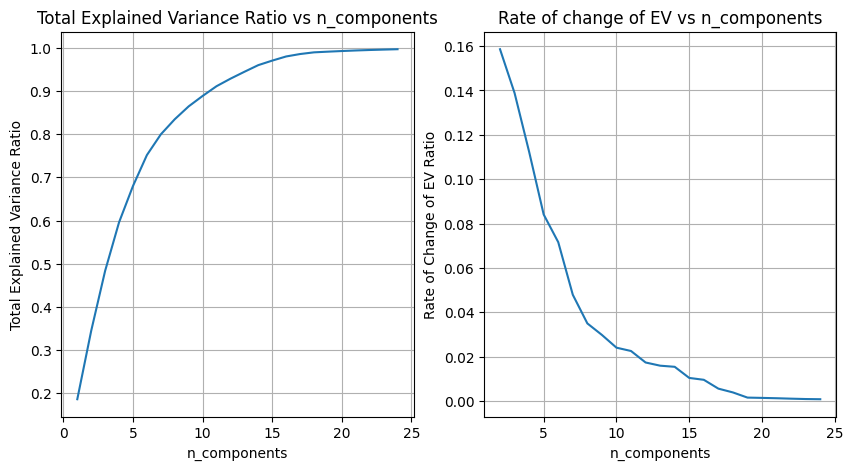

In [156]:
GLOBAL_RANDOM_STATE = 0


features = training_df.loc[:, training_df.columns != 'XNA_PRESENT']
labels = training_df['XNA_PRESENT']

scaler = StandardScaler()

scaled_features = features.copy()
scaled_features = pd.DataFrame(scaler.fit_transform(scaled_features))

component_list = list(np.arange(1,25, 1))
explained_variances = find_pca_components(component_list, scaled_features)

dy = np.diff(explained_variances)
dx = np.diff(component_list)

deriv = dy/dx
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(component_list, explained_variances)
ax[0].grid()
ax[0].set_title('Total Explained Variance Ratio vs n_components')
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Total Explained Variance Ratio')
ax[1].plot(component_list[1:], dy/dx)
ax[1].grid()
ax[1].set_title('Rate of change of EV vs n_components')
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('Rate of Change of EV Ratio')
print()

In [158]:
# Set up principal component analysis with 10 components, 
pca = PCA(n_components = 20, random_state=GLOBAL_RANDOM_STATE)
pca.fit(scaled_features)
x_pca = pca.transform(scaled_features)
evrs = pca.explained_variance_ratio_

labels.reset_index(drop=True)
x_tr, x_te, y_tr, y_te = train_test_split(x_pca,
                                          labels,
                                          test_size=.3,
                                          random_state = GLOBAL_RANDOM_STATE)

print("Component Variance Ratio: ", evrs)
print("Total Explained Variance Ratio: ", evrs.sum())

Component Variance Ratio:  [0.18624856 0.15856012 0.13881847 0.11234404 0.08407899 0.07162416
 0.04792559 0.03501145 0.02982248 0.02408112 0.02258169 0.0174062
 0.01596652 0.0154596  0.01044603 0.00960661 0.00562343 0.00391431
 0.00158654 0.00145165]
Total Explained Variance Ratio:  0.9925575559724917


### Parameter Optimization Stuff


In [229]:
# Set up device for pytorch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


# Convert training data to tensors
tr_x_tensor = torch.tensor(x_tr).type(torch.float).to(device)
tr_y_tensor = torch.tensor(np.asarray(y_tr)).type(torch.LongTensor).to(device)

# Convert testing data to tensors
te_x_tensor = torch.tensor(x_te).type(torch.float).to(device)
te_y_tensor = torch.tensor(np.asarray(y_te)).type(torch.LongTensor).to(device)

# number of features
feature_num = tr_x_tensor.shape[1]

out_features = 2

epochs = 100

l_rate = .1

rs=42

neurons=10
layers = 3

loss_fxn = nn.CrossEntropyLoss()
actv_fxn = nn.ReLU()

PTmodel = PyTorchClassifier(device=device,
                            n_features = feature_num,
                            out_features = out_features,
                            neurons = neurons,
                            layers = layers,
                            activation_function = actv_fxn,
                            loss_function = loss_fxn,
                            n_epochs=epochs,
                            learning_rate=l_rate,
                            random_state=rs)

PTmodel.train_model(tr_x_tensor, tr_y_tensor)
train_loss, train_acc = PTmodel.test_model(tr_x_tensor, tr_y_tensor)
test_loss, test_acc = PTmodel.test_model(te_x_tensor, te_y_tensor)

print("Training: {}, Testing: {}".format(train_acc, test_acc))

Training: 0.9603023529052734, Testing: 0.9568302035331726


In [103]:
''' FULL FACTORIAL COMBINATION TO FIND PARAMS
pytorch_params = {'device':[device],
                  'n_features':[feature_num],
                  'out_features':[out_features],
                  'neurons':[5, 10, 50, 100, 200],
                  'layers':[1, 5, 10, 20, 50],
                  'activation_function':[nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softmax()],
                  'loss_function':[nn.NLLLoss(),
                                   nn.CrossEntropyLoss()],
                  'n_epochs':[5, 10, 100, 1000],
                  'learning_rate':[.001, .01, 1],
                  'random_state':[rs]}

param_keys = list(pytorch_params.keys())
param_lists = []

for key in param_keys:
    value_list = pytorch_params[key]
    param_lists.append(value_list)
    
model_combos = list(itertools.product(*param_lists))
'''

" FULL FACTORIAL COMBINATION TO FIND PARAMS\npytorch_params = {'device':[device],\n                  'n_features':[feature_num],\n                  'out_features':[out_features],\n                  'neurons':[5, 10, 50, 100, 200],\n                  'layers':[1, 5, 10, 20, 50],\n                  'activation_function':[nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softmax()],\n                  'loss_function':[nn.NLLLoss(),\n                                   nn.CrossEntropyLoss()],\n                  'n_epochs':[5, 10, 100, 1000],\n                  'learning_rate':[.001, .01, 1],\n                  'random_state':[rs]}\n\nparam_keys = list(pytorch_params.keys())\nparam_lists = []\n\nfor key in param_keys:\n    value_list = pytorch_params[key]\n    param_lists.append(value_list)\n    \nmodel_combos = list(itertools.product(*param_lists))\n"

In [104]:
results_dict = {}

# Iteration index for keeping progress
i = 0

# Loop through each possible combination of parameters.
for params in model_combos:
    
    # Print percentage progress
    print(percenttobar(i/len(model_combos)), end='\r')
    
    # Generate the model from the current parameters
    test_model = PyTorchClassifier(*params)
    
    # Here, we generate the key of the model based on it's params
    key = params
    
    # Train the model
    test_model.train_model(tr_x_tensor, tr_y_tensor)
    
    # Test the model on training and testing data
    train_loss, train_acc = test_model.test_model(tr_x_tensor, tr_y_tensor)
    test_loss, test_acc = test_model.test_model(te_x_tensor, te_y_tensor)
    
    # Return the results to the dictionary
    results_dict[key] = [train_acc, test_acc]
    
    # Incriment the progress tracker
    i+=1

NameError: name 'model_combos' is not defined

In [105]:
# Get the results into a dataframe
results_df = pd.DataFrame.from_dict(results_dict, orient='index')
vals = results_df.index.tolist()
results_clean = pd.DataFrame(vals)
results_clean = results_clean.rename(columns={0:'comp.', 1:'features', 2:'categories', 3:'neurons', 4:'layers',5:'act_func',6:'loss_func',7:'epochs',8:'learn_rate', 9:'rand_state'})
results_clean['training_score'] = results_df[0].apply(lambda x: float(str(x).split("tensor(")[1].split(",")[0])).values
results_clean['testing_score'] = results_df[1].apply(lambda x: float(str(x).split("tensor(")[1].split(",")[0])).values
results_clean['diff'] = results_clean['training_score'] - results_clean['testing_score']
results_clean.sort_values('testing_score', ascending=False)

vals = results_df.index()
train = results_df[0].apply(lambda x: float(str(x).split("tensor(")[1].split(",")[0]))
test = results_df[1].apply(lambda x: float(str(x).split("tensor(")[1].split(",")[0]))

top_training_model = list(train.sort_values(ascending=False).index)[0]
top_training_acc = train.sort_values(ascending=False)[0]
top_testing_model = list(test.sort_values(ascending=False).index)[0]
top_testing_acc = test.sort_values(ascending=False)[0]

KeyError: 0

In [79]:
print("Best training model: {}, Results = {}, {}".format(top_training_model, top_training_acc, test[test.index == top_training_model][0]))
print("Best tresting model: {}, Results = {}, {}".format(top_testing_model, train[train.index == top_testing_model][0], top_testing_acc))

Best training model: ('cuda', 12, 2, 100, 5, LeakyReLU(negative_slope=0.01), CrossEntropyLoss(), 1000, 1, 42), Results = 0.9996, 0.9975
Best tresting model: ('cuda', 12, 2, 50, 5, Tanh(), CrossEntropyLoss(), 1000, 1, 42), Results = 0.9992, 0.9977


In [78]:
test[test.index == top_training_model][0]

0.9975

In [80]:
test.sort_values(ascending=False)

(cuda, 12, 2, 50, 5, Tanh(), CrossEntropyLoss(), 1000, 1, 42)                              0.9977
(cuda, 12, 2, 200, 5, ReLU(), CrossEntropyLoss(), 1000, 1, 42)                             0.9977
(cuda, 12, 2, 100, 5, LeakyReLU(negative_slope=0.01), CrossEntropyLoss(), 1000, 1, 42)     0.9975
(cuda, 12, 2, 100, 5, ReLU(), CrossEntropyLoss(), 1000, 1, 42)                             0.9975
(cuda, 12, 2, 100, 10, LeakyReLU(negative_slope=0.01), CrossEntropyLoss(), 1000, 1, 42)    0.9974
                                                                                            ...  
(cuda, 12, 2, 200, 1, Sigmoid(), CrossEntropyLoss(), 10, 0.01, 42)                         0.0001
(cuda, 12, 2, 200, 1, Sigmoid(), CrossEntropyLoss(), 100, 0.001, 42)                       0.0001
(cuda, 12, 2, 200, 1, Tanh(), NLLLoss(), 5, 0.001, 42)                                     0.0001
(cuda, 12, 2, 200, 1, Tanh(), NLLLoss(), 5, 0.01, 42)                                      0.0001
(cuda, 12, 2, 200, 1

### Model Validation

In [177]:
# Set up device for pytorch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


# Convert training data to tensors
tr_x_tensor = torch.tensor(x_tr).type(torch.float).to(device)
tr_y_tensor = torch.tensor(np.asarray(y_tr)).type(torch.LongTensor).to(device)

# Convert testing data to tensors
te_x_tensor = torch.tensor(x_te).type(torch.float).to(device)
te_y_tensor = torch.tensor(np.asarray(y_te)).type(torch.LongTensor).to(device)

# number of features
feature_num = tr_x_tensor.shape[1]

out_features = 2

epochs = 2000

l_rate = .01

rs=42

neurons=50
layers = 3

loss_fxn = nn.CrossEntropyLoss()
actv_fxn = nn.Tanh()

PTmodel = PyTorchClassifier(device=device,
                            n_features = feature_num,
                            out_features = out_features,
                            neurons = neurons,
                            layers = layers,
                            activation_function = actv_fxn,
                            loss_function = loss_fxn,
                            n_epochs=epochs,
                            learning_rate=l_rate,
                            random_state=rs)

PTmodel.train_model(tr_x_tensor, tr_y_tensor)
train_loss, train_acc = PTmodel.test_model(tr_x_tensor, tr_y_tensor)
test_loss, test_acc = PTmodel.test_model(te_x_tensor, te_y_tensor)

print("Training: {}, Testing: {}".format(train_acc, test_acc))
print("Training misclassified/strand: {}, Testing misclassified/strand: {}".format(1-(132-train_acc.item()*132),1-(132-test_acc.item()*132)))

Training: 0.9719980955123901, Testing: 0.9725914001464844
Training misclassified/strand: -2.696251392364502, Testing misclassified/strand: -2.6179351806640625


[(41, 1), (42, 1), (63, 1), (65, 1), (66, 2), (85, 1), (88, 1)]


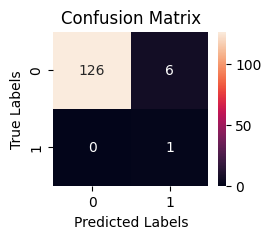

In [196]:
predictions = []
trues = []
idx=99
top = batch_ranges[idx][1]
bot = batch_ranges[idx][0]
for i in range(top-bot + 1):
    test_consensus = pd.concat(feature_read_list[bot+i:bot+i+1])[:]
    test_xna_bases = test_consensus[test_consensus['XNA_PRESENT'] == 1]#.reset_index(drop=True)
    test_rand_bases = test_consensus[test_consensus['XNA_PRESENT'] == 0]
    training_df = pd.concat([test_xna_bases, test_rand_bases]).reset_index(drop=True)
    #test_consensus = test_consensus.dropna(how='any')

    strand_features = torch.tensor(pca.transform(test_consensus.loc[:, test_consensus.columns != 'XNA_PRESENT'])).type(torch.float).to(device)
    strand_labels = torch.tensor(np.asarray(test_consensus['XNA_PRESENT'])).type(torch.LongTensor).to(device)

    strand_logits = PTmodel.model(strand_features)

    strand_predictions = torch.softmax(strand_logits, dim=1).argmax(dim=1)
    predictions.append(strand_predictions.tolist())
    trues.append(strand_labels.tolist())
comp_df = pd.DataFrame(predictions)
t_df = pd.DataFrame(trues)
sum_true = t_df.sum()
sum_pred = comp_df.sum()
sum_true[sum_true > 0]=1
sum_pred[sum_pred > 0]=1

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(sum_true.tolist(), sum_pred.tolist())
fig, ax = plt.subplots(1, figsize=(2.5, 2))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
indexes = list(sum_pred[sum_pred > 0].index)
sums = list(comp_df.sum()[comp_df.sum() > 0])
print(list(zip(indexes, sums)))
plt.show()

In [113]:
comp_df = pd.DataFrame([strand_labels.tolist(), strand_predictions.tolist()]).T
comp_df = comp_df.rename(columns={0:"True Label", 1:"Predicted Label"})

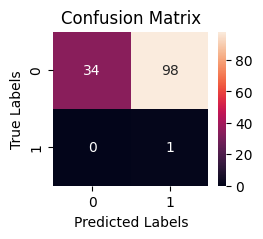

In [114]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(sum_true.tolist(), sum_pred.tolist())
fig, ax = plt.subplots(1, figsize=(2.5, 2))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.show()

In [235]:
len(test_consensus)

2660

In [69]:
np.asarray(test_consensus['XNA_PRESENT'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [70]:
strand_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')